In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import scipy
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from google.colab import files
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/content/drive/MyDrive/GlobalLandTemperaturesByMajorCity.csv')

In [3]:
df.shape

(239177, 7)

In [4]:
df.columns.values

array(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty',
       'City', 'Country', 'Latitude', 'Longitude'], dtype=object)

In [5]:
df.isna().sum()

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [6]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


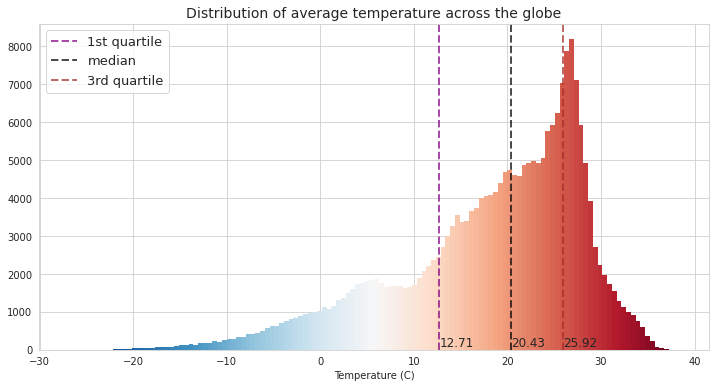

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
cm = plt.cm.RdBu_r
bn = int((int(df['AverageTemperature'].max()) - int(df['AverageTemperature'].min()))/0.5)
n, bins, patches = plt.hist(df['AverageTemperature'], bins=bn, edgecolor='none', alpha=1)
plt.xlabel('Temperature (C)')
plt.title('Distribution of average temperature across the globe', fontsize=14)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/bn)) # notice the i/25

plt.axvline(x = df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.25], color = 'purple', label = '1st quartile', linestyle='dashed', alpha=0.7, linewidth=2)
plt.text(df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.25], 100, str(round(df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.25],2)), fontsize=12)
plt.axvline(x = df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.5], color = 'black', label = 'median', linestyle='dashed', alpha=0.7, linewidth=2)
plt.text(df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.5], 100, str(round(df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.5],2)), fontsize=12)
plt.axvline(x = df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.75], color = 'brown', label = '3rd quartile', linestyle='dashed', alpha=0.7, linewidth=2)
plt.text(df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.75], 100, str(round(df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.75],2)), fontsize=12)

plt.legend(loc=2, fontsize=13)
plt.show()

In [13]:
df['AverageTemperature'].quantile([0.25, 0.5, 0.75])[0.25]

12.71

In [8]:
np.sort(df['Country'].unique())

array(['Afghanistan', 'Angola', 'Australia', 'Bangladesh', 'Brazil',
       'Burma', 'Canada', 'Chile', 'China', 'Colombia',
       'Congo (Democratic Republic Of The)', "Côte D'Ivoire",
       'Dominican Republic', 'Egypt', 'Ethiopia', 'France', 'Germany',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Japan', 'Kenya',
       'Mexico', 'Morocco', 'Nigeria', 'Pakistan', 'Peru', 'Philippines',
       'Russia', 'Saudi Arabia', 'Senegal', 'Singapore', 'Somalia',
       'South Africa', 'South Korea', 'Spain', 'Sudan', 'Syria', 'Taiwan',
       'Tanzania', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom',
       'United States', 'Vietnam', 'Zimbabwe'], dtype=object)

In [32]:
ind_df = df[df['Country']=='India']
uk_df = df[df['Country']=='United Kingdom']
br_df = df[df['Country']=='Brazil']


print(ind_df['City'].unique())
print(uk_df['City'].unique())
print(br_df['City'].unique())

['Ahmadabad' 'Bangalore' 'Bombay' 'Calcutta' 'Delhi' 'Hyderabad' 'Jaipur'
 'Kanpur' 'Lakhnau' 'Madras' 'Nagpur' 'New Delhi' 'Pune' 'Surat']
['London']
['Belo Horizonte' 'Brasília' 'Fortaleza' 'Rio De Janeiro' 'São Paulo'
 'Salvador']


In [33]:
cdf1 = ind_df[ind_df['City']=='Calcutta']
cdf2 = uk_df[uk_df['City']=='London']
cdf3 = br_df[br_df['City']=='Rio De Janeiro']

In [34]:
print('Calcutta:',cdf1.shape)
print('London:',cdf2.shape)
print('Rio De Janeiro:',cdf3.shape)

Calcutta: (2613, 7)
London: (3239, 7)
Rio De Janeiro: (2181, 7)


In [35]:
cdf1.isna().sum()

dt                                0
AverageTemperature               81
AverageTemperatureUncertainty    81
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

In [36]:
cdf2.isna().sum()

dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

In [37]:
cdf3.isna().sum()

dt                                0
AverageTemperature               85
AverageTemperatureUncertainty    85
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

In [38]:
cities = [cdf1, cdf2, cdf3]

In [39]:
cdf3.loc[cdf3.index[0]]

dt                                   1832-01-01
AverageTemperature                        25.32
AverageTemperatureUncertainty             1.508
City                             Rio De Janeiro
Country                                  Brazil
Latitude                                 23.31S
Longitude                                42.82W
Name: 183791, dtype: object

In [40]:
for c in cities:
  c['AverageTemperature']=c['AverageTemperature'].fillna(method='ffill')
  c['AverageTemperatureUncertainty']=c['AverageTemperatureUncertainty'].fillna(method='ffill')


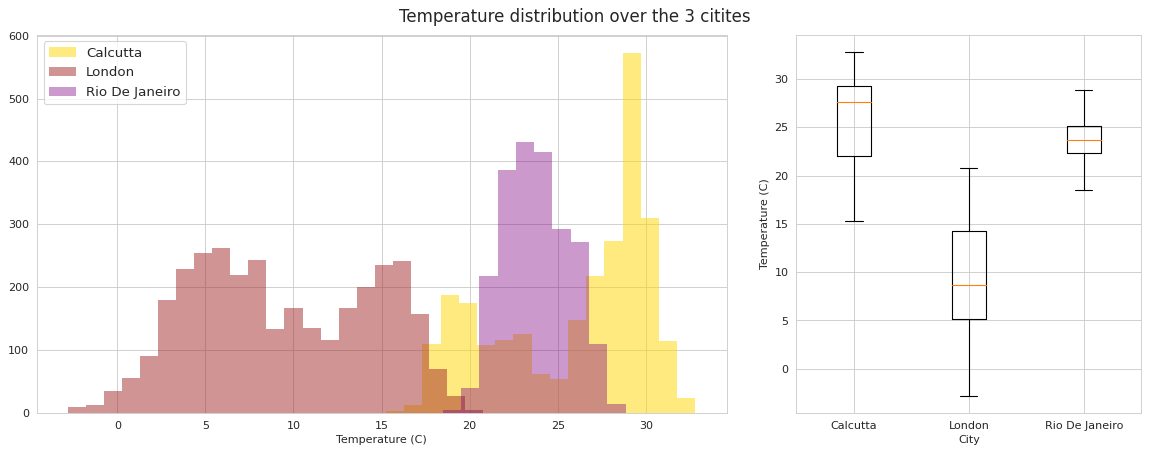

In [41]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10,7))
fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi= 80, gridspec_kw={'width_ratios': [2, 1]})

axes[0].hist(cdf1['AverageTemperature'], bins=int((cdf1['AverageTemperature'].max()-cdf1['AverageTemperature'].min())/1), color='gold', alpha=0.5, label='Calcutta', edgecolor='none')
axes[0].hist(cdf2['AverageTemperature'], bins=int((cdf2['AverageTemperature'].max()-cdf2['AverageTemperature'].min())/1), color='brown', alpha=0.5, label='London', edgecolor='none')
axes[0].hist(cdf3['AverageTemperature'], bins=int((cdf3['AverageTemperature'].max()-cdf3['AverageTemperature'].min())/1), color='purple', alpha=0.4, label='Rio De Janeiro', edgecolor='none')
axes[0].legend(loc=2, prop={'size': 12})
axes[0].set_xlabel('Temperature (C)')

city_dict = {'Calcutta': cdf1['AverageTemperature'], 'London': cdf2['AverageTemperature'], 'Rio De Janeiro': cdf3['AverageTemperature']}
axes[1].boxplot(city_dict.values())
axes[1].set_xticklabels(city_dict.keys())
axes[1].set_xlabel('City')
axes[1].set_ylabel('Temperature (C)')


plt.suptitle('Temperature distribution over the 3 citites', fontsize=15)
plt.tight_layout(pad=3)
plt.show()

In [42]:
cdf1.reset_index(inplace=True)
cdf1.drop(['index'], axis=1, inplace=True)
cdf1.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1796-01-01,18.708,2.305,Calcutta,India,23.31N,88.25E
1,1796-02-01,21.505,1.717,Calcutta,India,23.31N,88.25E
2,1796-03-01,25.230,2.404,Calcutta,India,23.31N,88.25E
3,1796-04-01,29.484,1.902,Calcutta,India,23.31N,88.25E
4,1796-05-01,30.980,1.656,Calcutta,India,23.31N,88.25E


In [43]:
def add_features(city_df):
  city_df['dt'] = pd.to_datetime(city_df['dt'])
  Weekday = []
  Day = []
  Month = []
  Year = []

  for i in range(len(city_df)):
    Weekday.append(city_df['dt'].iloc[i].weekday())
    Day.append(city_df['dt'].iloc[i].day)
    Month.append(city_df['dt'].iloc[i].month)
    Year.append(city_df['dt'].iloc[i].year)

  city_df['Weekday'] = Weekday
  city_df['Day'] = Day
  city_df['Month'] = Month
  city_df['Year'] = Year

  return city_df

In [44]:
cdf1 = add_features(cdf1)

In [45]:
cdf2 = add_features(cdf2)

In [46]:
cdf3 = add_features(cdf3)

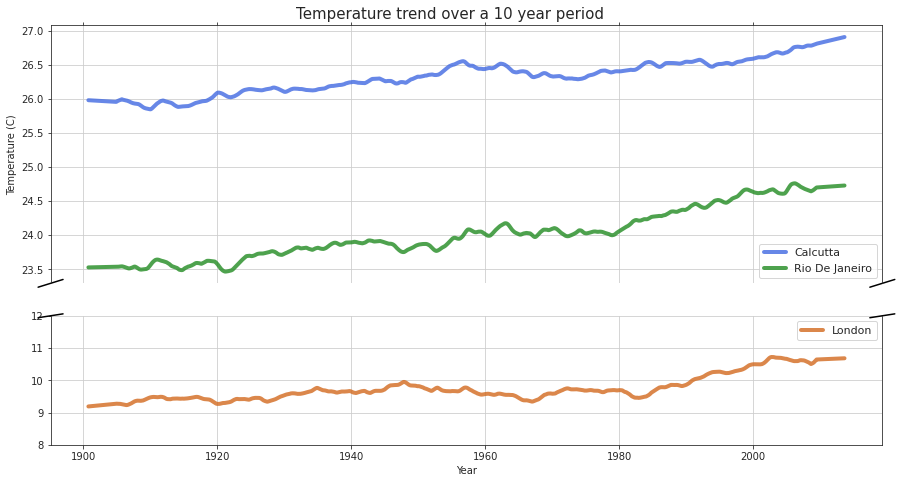

In [50]:
sns.set_style('ticks')

color_for_trends = ['royalblue', 'chocolate', 'forestgreen']
cft_id = 0
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13,7), gridspec_kw={'height_ratios': [2, 1]})
for c in cities:
  cit = c[c['Year']>=1900][['dt', 'AverageTemperature']]
  cit.set_index('dt', inplace=True)
  result_add = seasonal_decompose(cit, model='additive', period=120, extrapolate_trend='freq')
  temps = result_add.trend
  # mx = temps.max()
  # mn = temps.min()
  # for i in temps.index:
  #   temps.loc[i] = (temps.loc[i]-mn)/(mx-mn)
  if c['City'].loc[c.index[0]]!='London':
    ax.plot(temps.index, temps.rolling(10).mean(), color=color_for_trends[cft_id], alpha=0.8, linewidth=4, label=['Calcutta', 'London', 'Rio De Janeiro'][cft_id])
    cft_id+=1

  elif c['City'].loc[c.index[0]]=='London':
    ax2.plot(temps.index, temps.rolling(10).mean(), color=color_for_trends[cft_id], alpha=0.8, linewidth=4, label=['Calcutta', 'London', 'Rio De Janeiro'][cft_id])
    cft_id+=1

# ax.set_ylim(22,28)
# ax2.set_ylim(7,13)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax.legend(prop={'size': 11}, loc=4)
ax.grid()

ax2.legend(prop={'size': 11}, loc=1)
ax2.grid()
d = .015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax2.set_yticks(range(8,13))

ax.set_ylabel('Temperature (C)')
ax2.set_xlabel('Year')

plt.suptitle('Temperature trend over a 10 year period', fontsize=15)
plt.tight_layout(pad=2.5)
plt.show()

In [257]:
def plot_temperature(cdf, id):
  cits = ['Calcutta', 'London', 'Rio De Janeiro']
  cal = cdf[cdf['Year']>=2000]
  plt.figure(figsize=(15,3))
  plt.plot(cal['dt'], cal['AverageTemperature'])
  plt.title(cits[id], fontsize=12)
  plt.ylabel('Temperature (C)')
  plt.show()

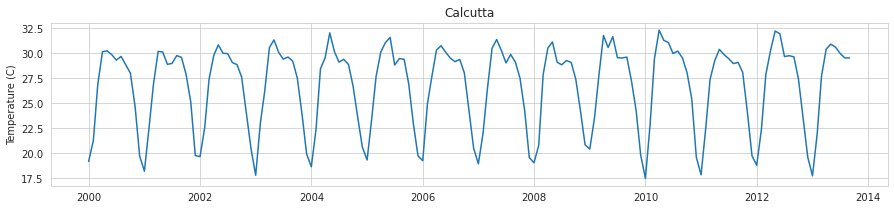

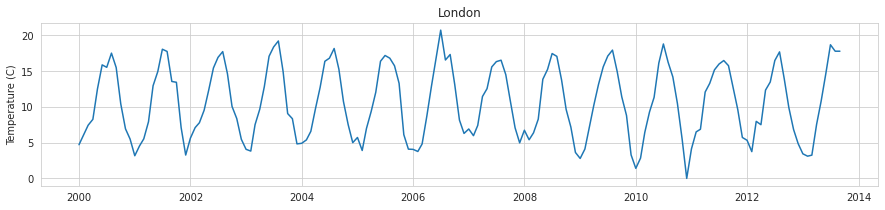

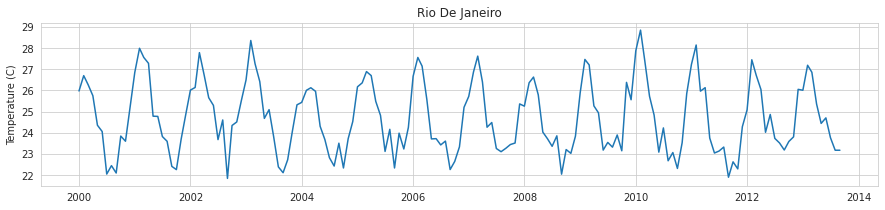

In [258]:
plot_temperature(cdf1, 0)
plot_temperature(cdf2, 1)
plot_temperature(cdf3, 2)

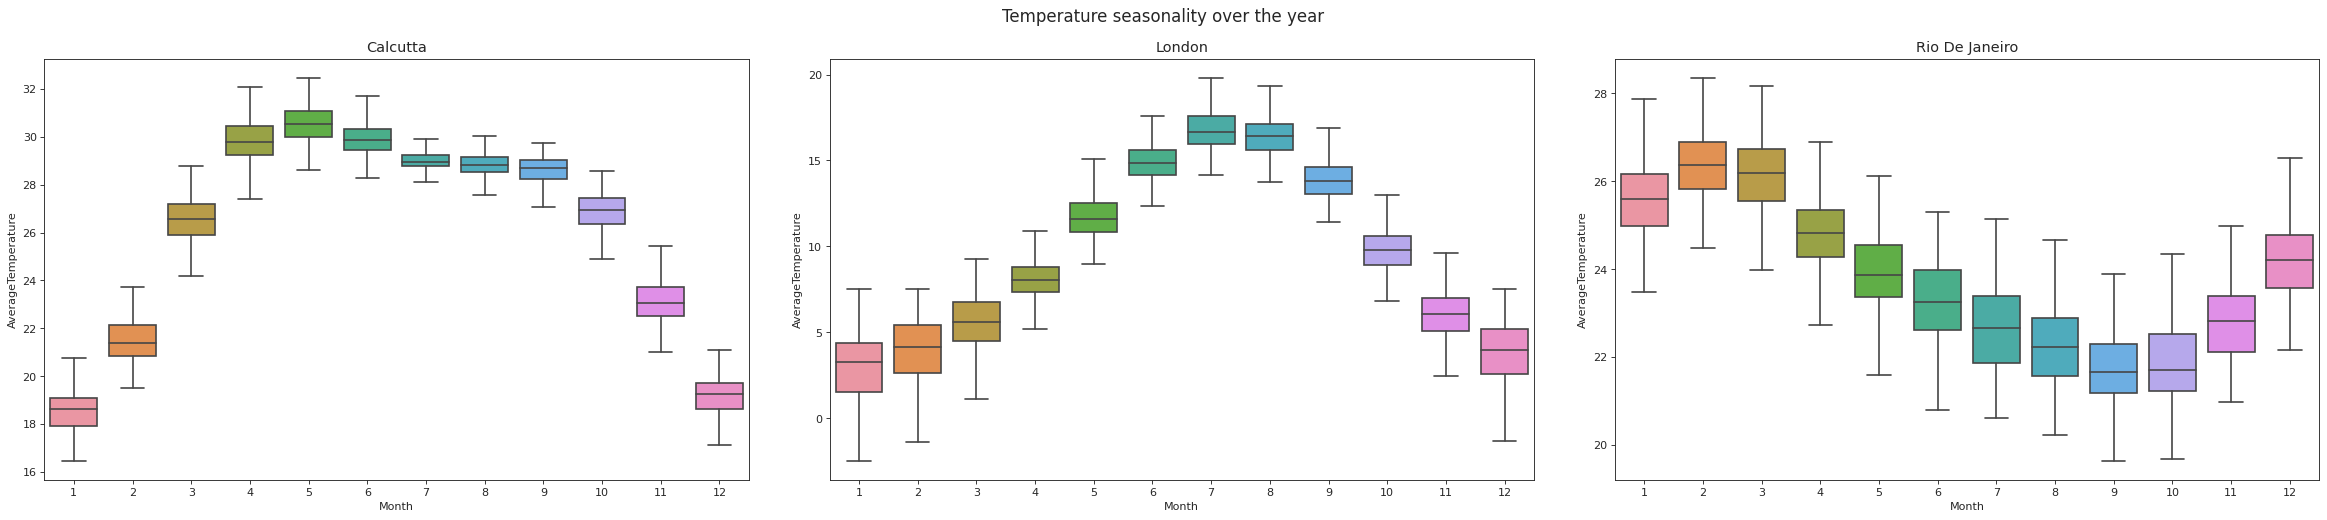

In [285]:
fig, axes = plt.subplots(1, 3, figsize=(30,7), dpi= 80, gridspec_kw={'width_ratios': [1, 1, 1]})
sns.boxplot(x='Month', y='AverageTemperature', data=cdf1, ax=axes[0], showfliers=False)
axes[0].set_title('Calcutta', fontsize=13)
sns.boxplot(x='Month', y='AverageTemperature', data=cdf2, ax=axes[1], showfliers=False)
axes[1].set_title('London', fontsize=13)
sns.boxplot(x='Month', y='AverageTemperature', data=cdf3, ax=axes[2], showfliers=False)
axes[2].set_title('Rio De Janeiro', fontsize=13)
plt.suptitle('Temperature seasonality over the year', fontsize=15)
plt.tight_layout(pad=4)
plt.show()

In [158]:
cal_pred = cdf1[((cdf1['Year']>=2000)&(cdf1['Year']<=2010))]
lon_pred = cdf2[((cdf2['Year']>=2000)&(cdf2['Year']<=2010))]
rdj_pred = cdf3[((cdf3['Year']>=2000)&(cdf3['Year']<=2010))]

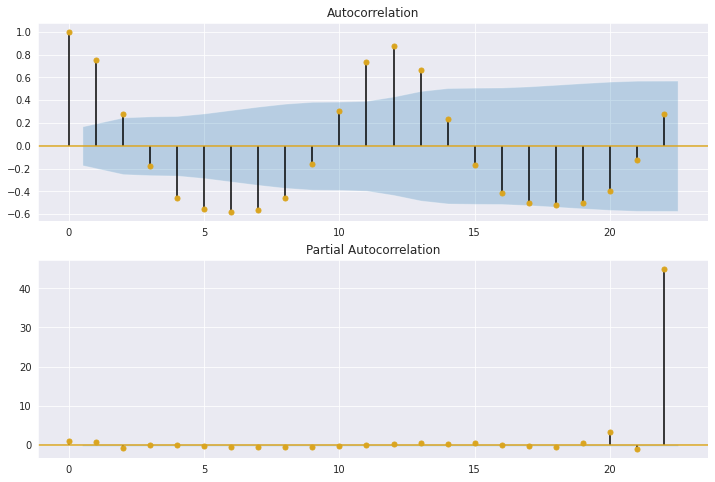

In [159]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(cal_pred['AverageTemperature'], ax=ax1,color ='goldenrod')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(cal_pred['AverageTemperature'], ax=ax2,color='goldenrod')

In [160]:
result = adfuller(cal_pred['AverageTemperature'])
print('ADF Statistic for a decade for city of Calcutta: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic for a decade for city of Calcutta: -1.5513343987263877
p-value: 0.5079815785891492
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


In [161]:
cal_z1 = []
for i in range(len(cal_pred.index)-1):
  diff = cal_pred['AverageTemperature'].loc[cal_pred.index[i+1]]-cal_pred['AverageTemperature'].loc[cal_pred.index[i]]
  cal_z1.append(diff)

result = adfuller(cal_z1)
print('ADF Statistic of 1st difference: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic of 1st difference: -6.550869320174255
p-value: 8.858091091402008e-09
Critical Values:
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012


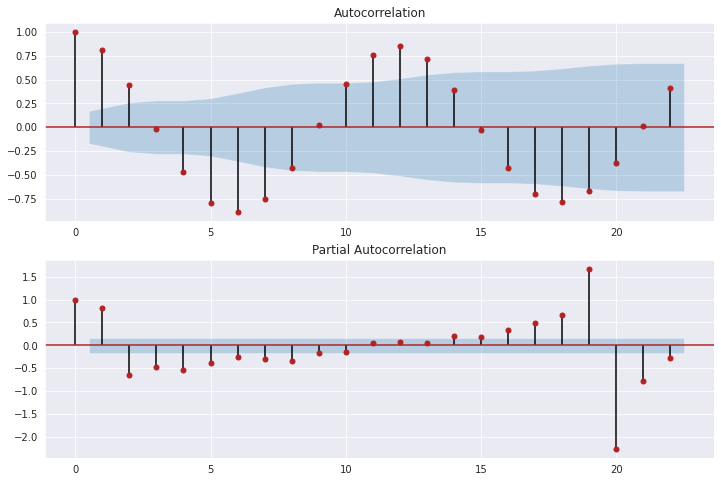

In [162]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(lon_pred['AverageTemperature'], ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(lon_pred['AverageTemperature'], ax=ax2,color='firebrick')

In [163]:
result = adfuller(lon_pred['AverageTemperature'])
print('ADF Statistic for a decade for city of London: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic for a decade for city of London: -1.2288251956924272
p-value: 0.661074580011341
Critical Values:
	1%: -3.486055829282407
	5%: -2.8859430324074076
	10%: -2.5797850694444446


In [164]:
lon_z1 = []
for i in range(len(lon_pred.index)-1):
  diff = lon_pred['AverageTemperature'].loc[lon_pred.index[i+1]]-lon_pred['AverageTemperature'].loc[lon_pred.index[i]]
  lon_z1.append(diff)

result = adfuller(lon_z1)
print('ADF Statistic of 1st difference: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic of 1st difference: -9.27663324265689
p-value: 1.2837472335018562e-15
Critical Values:
	1%: -3.486055829282407
	5%: -2.8859430324074076
	10%: -2.5797850694444446


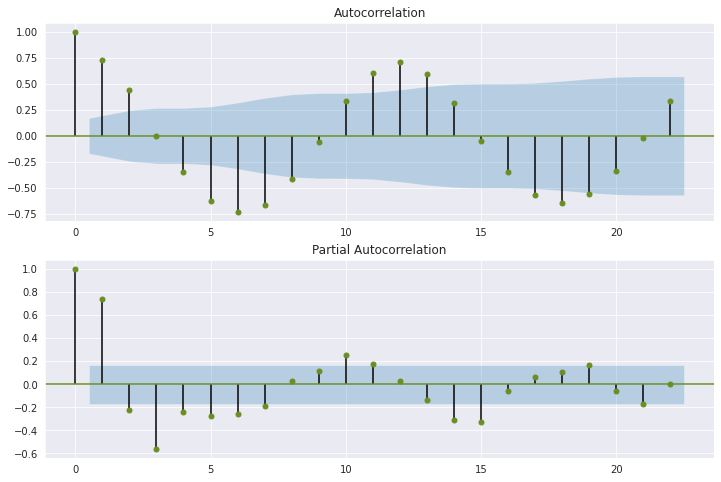

In [165]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rdj_pred['AverageTemperature'], ax=ax1,color ='olivedrab')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(rdj_pred['AverageTemperature'], ax=ax2,color='olivedrab')

In [166]:
result = adfuller(rdj_pred['AverageTemperature'])
print('ADF Statistic for a decade for city of Rio De Janeiro: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic for a decade for city of Rio De Janeiro: -2.5948602438825645
p-value: 0.0940642103625996
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


In [167]:
rdj_z1 = []
for i in range(len(rdj_pred.index)-1):
  diff = rdj_pred['AverageTemperature'].loc[rdj_pred.index[i+1]]-rdj_pred['AverageTemperature'].loc[rdj_pred.index[i]]
  rdj_z1.append(diff)

result = adfuller(rdj_z1)
print('ADF Statistic of 1st difference: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic of 1st difference: -3.389259879934539
p-value: 0.011330496058426731
Critical Values:
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012


In [247]:
def plot_forecasts(data, y, m=0):
  
  sns.set_style('whitegrid')
  fig, ax = plt.subplots(1, 2, figsize=(25,6), dpi= 80, gridspec_kw={'width_ratios': [2, 1]})

  limit = data[((data['Year']>y)&(data['Month']>m))].index[0]
  train = data.loc[:limit]
  test = data.loc[limit+1:]
  train = train[['dt', 'AverageTemperature']]
  test = test[['dt', 'AverageTemperature']]
  train.set_index('dt', inplace=True)
  test.set_index('dt', inplace=True)
  ax[0].plot(train, label='Train', color='b')
  ax[0].plot(test, label='Test', color='y')
  ax[0].set_title('Training and test sets')
  ax[0].legend(loc='upper right', fontsize=12)
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Temperature (C)')

  best_model = pd.DataFrame(columns=['(p,d,q)', 'AIC'])
  bmid = 0

  for ar in range(1,10):
    for ma in range(1,10):
      try:
        model = ARIMA(train, order=(ar,1,ma))
        model_fit = model.fit()
        best_model.loc[bmid]=[(ar,1,ma), model_fit.aic]
        bmid+=1
      except:
        continue

  best_model = best_model.sort_values('AIC').reset_index(drop=True)

  f_model = ARIMA(train, order=best_model['(p,d,q)'].loc[0])

  f_model_fit = f_model.fit()

  plt.figure(figsize=(10,6))
  fc, se, conf = f_model_fit.forecast(len(test), alpha=0.05)

  fc_series = pd.Series(fc, index=test.index)
  lower_series = pd.Series(conf[:, 0], index=test.index)
  upper_series = pd.Series(conf[:, 1], index=test.index)

  ax[1].plot(test, label='actual', color='blue', linestyle='dashed')
  ax[1].plot(fc_series, label='forecast', color='red')
  ax[1].fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
  ax[1].set_title('Forecast vs Observed')
  ax[1].legend(loc='upper right', fontsize=12)
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('Temperature (C)')
  ax[1].set_xticks(ax[1].get_xticks()[::2])


  plt.suptitle('Forecast visuals')

  print('Best model parameters', end='\n\n')
  print(best_model.loc[0])
  plt.tight_layout()
  plt.show()

# Long term forecast

## Calcutta

Best model parameters

(p,d,q)     (9, 1, 2)
AIC        280.339718
Name: 0, dtype: object


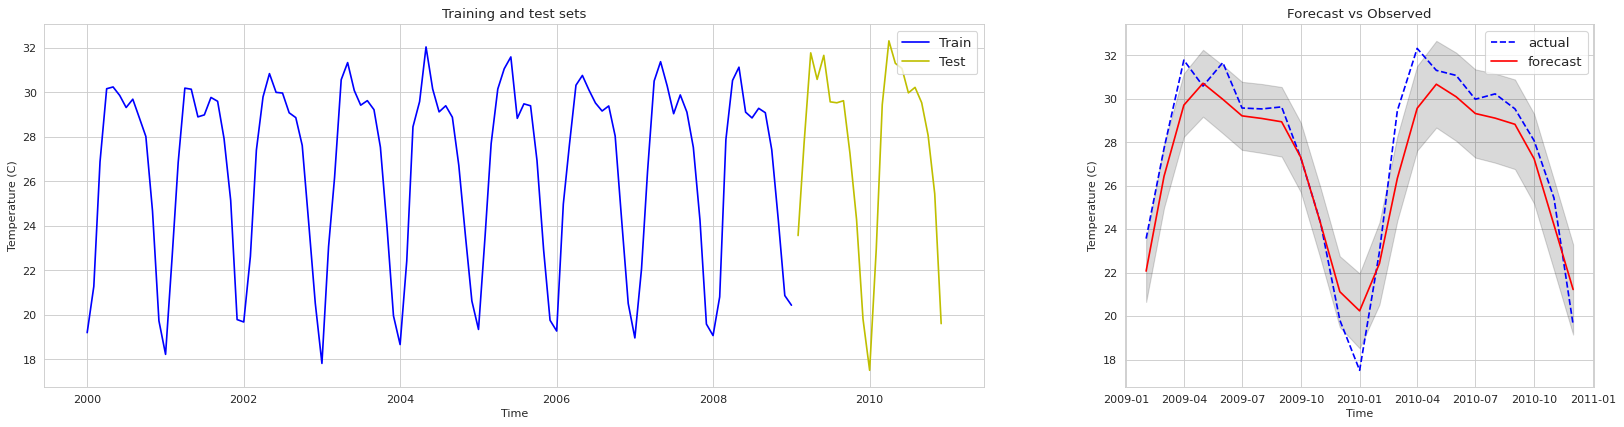

<Figure size 720x432 with 0 Axes>

In [174]:
plot_forecasts(cal_pred, 2008)

## London

Best model parameters

(p,d,q)     (8, 1, 9)
AIC        371.556773
Name: 0, dtype: object


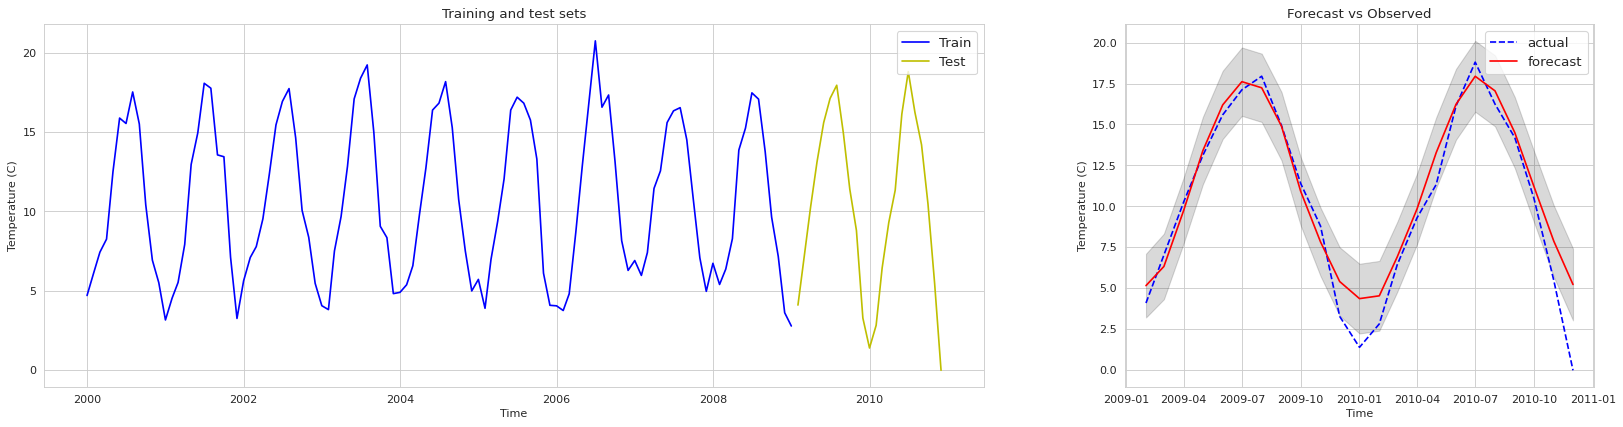

<Figure size 720x432 with 0 Axes>

In [175]:
plot_forecasts(lon_pred, 2008)

## Rio De Janeiro

Best model parameters

(p,d,q)     (6, 1, 2)
AIC        252.743265
Name: 0, dtype: object


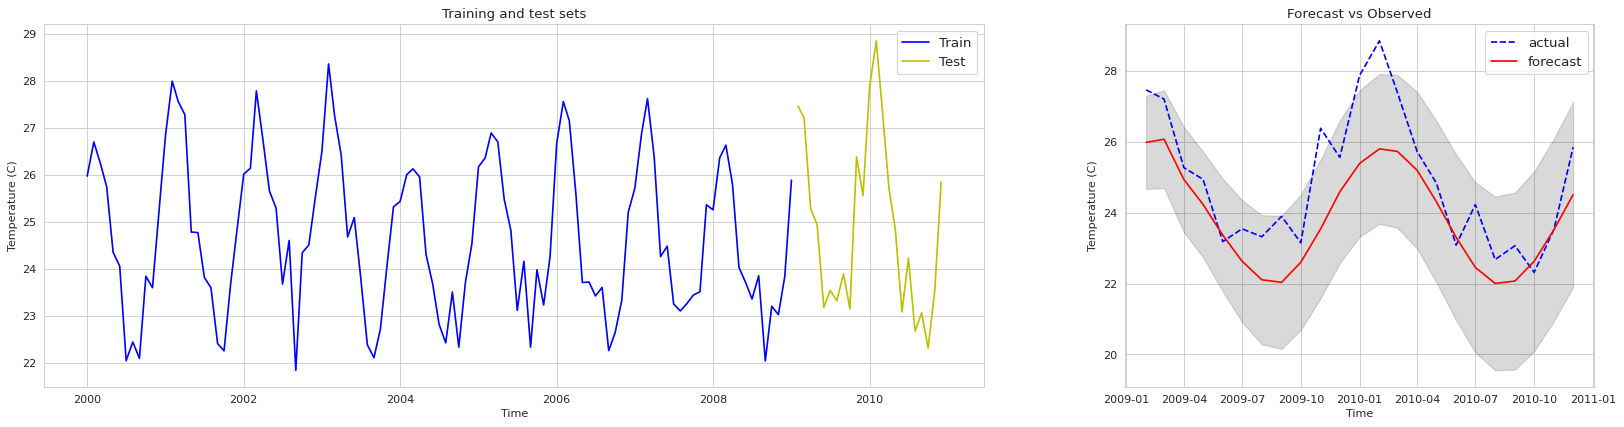

<Figure size 720x432 with 0 Axes>

In [176]:
plot_forecasts(rdj_pred, 2008)

# Short term forecasts

## Calcutta

Best model parameters

(p,d,q)     (8, 1, 4)
AIC        345.215004
Name: 0, dtype: object


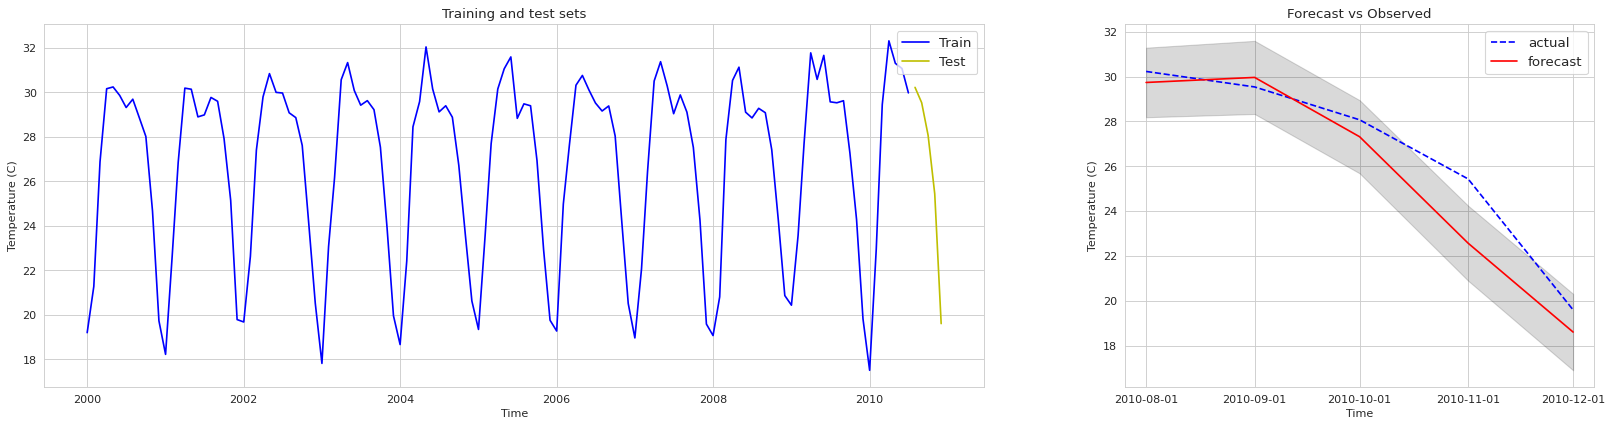

<Figure size 720x432 with 0 Axes>

In [248]:
plot_forecasts(cal_pred, 2009, 6)

## London

Best model parameters

(p,d,q)     (2, 1, 4)
AIC        422.171348
Name: 0, dtype: object


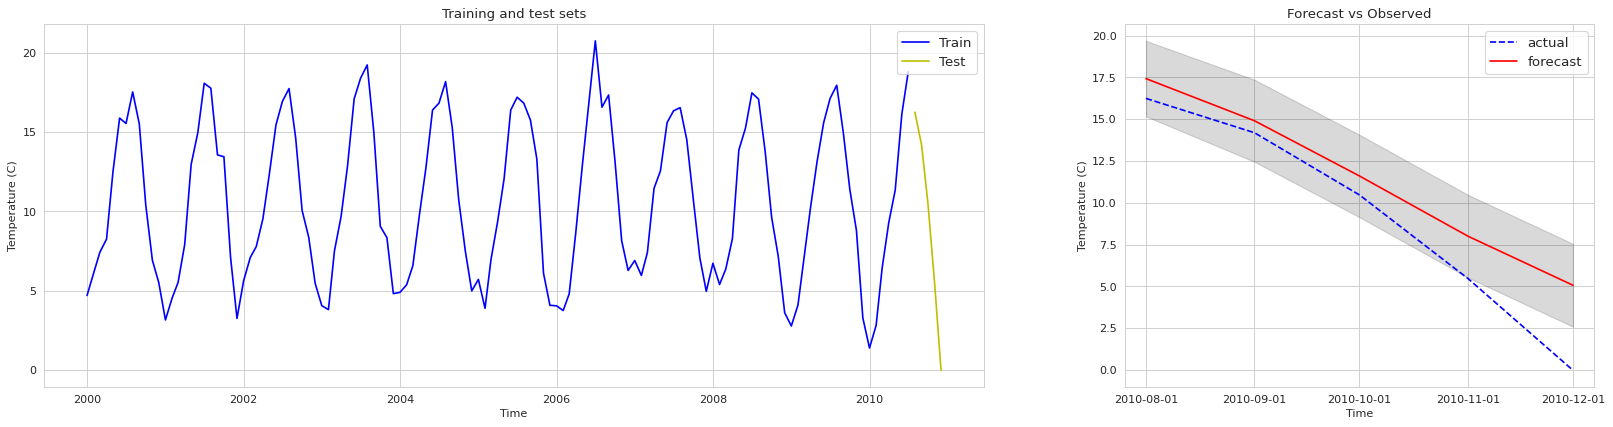

<Figure size 720x432 with 0 Axes>

In [249]:
plot_forecasts(lon_pred, 2009, 6)

## Rio De Janeiro

Best model parameters

(p,d,q)     (2, 1, 5)
AIC        307.010705
Name: 0, dtype: object


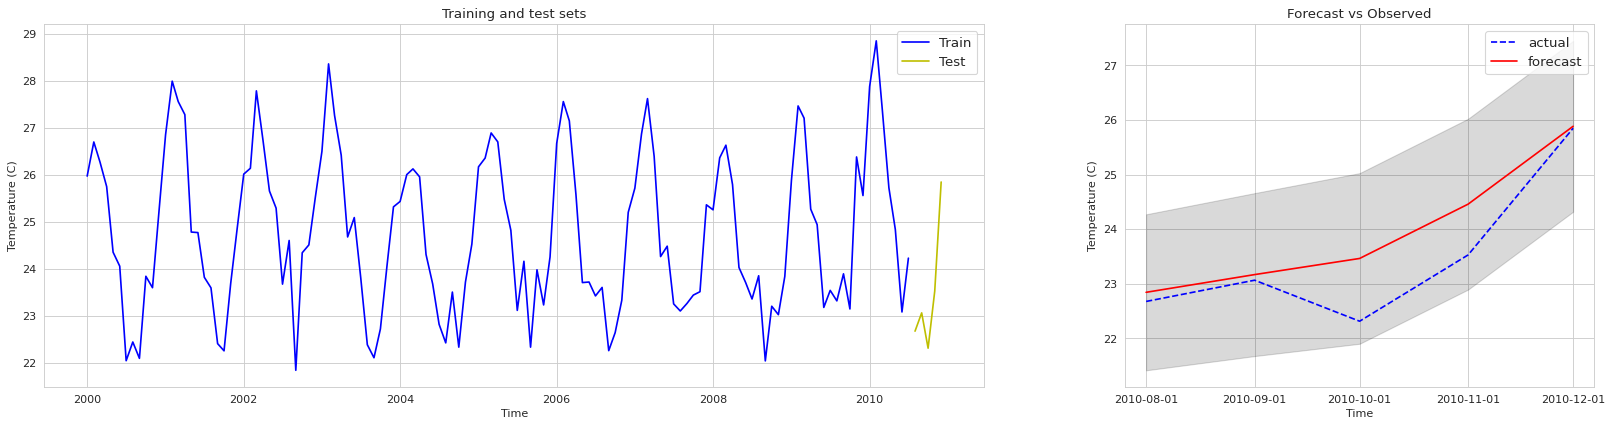

<Figure size 720x432 with 0 Axes>

In [250]:
plot_forecasts(rdj_pred, 2009, 6)